In [23]:
from pathlib import Path

import causalpy as cp
import plotnine as pn
import polars as pl
import srsly
import statsmodels.formula.api as smf
from datasets import load_from_disk

In [2]:
run_path = Path("outputs/model_eval/smol_llama-81M-tied_bpe32000minipile_last_2024-09-30T19-42-18_2024-10-02T16-09-12")
df = pl.read_parquet(run_path / "eval_last.parquet")

In [24]:
eval_df = pl.from_arrow(load_from_disk("data/minipile-eval-bpe32000minipile/eval_samples/").data.table)

In [26]:
eval_df

new_token_id,uid,input_ids
i32,u64,list[i32]
31600,1,"[1636, 71, … 31600]"
30946,1,"[1450, 93, … 30946]"
30960,1,"[4681, 93, … 30960]"
31600,1,"[63, 91, … 31600]"
31600,1,"[704, 943, … 31600]"
…,…,…
31978,9153,"[1219, 1668, … 31978]"
31684,9293,"[19802, 1010, … 31684]"
30623,9405,"[5627, 354, … 30623]"


In [4]:
# def flatten(x: list[list]) -> list:
#     return [i for j in x for i in j]


# def ld_to_dl(ld: list[dict]) -> dict[str, list]:
#     return {k: [dic[k] for dic in ld] for k in ld[0]}


# fl = srsly.read_jsonl(
#     "/home/pl487/rdd/outputs/model_eval/pythia-9M-bpe32000_checkpoint-50000_2024-09-17T17-15-44/pythia-9M-bpe32000_checkpoint-50000.jsonl"
# )
# df = pl.DataFrame({k: flatten(v) for k, v in ld_to_dl(line).items()} for line in fl)  # type: ignore
# df = df.explode(df.columns)

In [5]:
raw_tok_path = Path("/home/pl487/rdd/outputs/tok_train/bpe_minipile_2024-09-22T17-58-54")
tok = pl.DataFrame(srsly.read_jsonl(Path(raw_tok_path) / "implemented_merges.jsonl"))

In [6]:
tok_type = "bpe"
vocab_size = 32_000

In [7]:
EPS = 1e-8
df = (
    df.with_columns(is_out_vocab=pl.col("new_token_id") >= vocab_size).with_columns(
        log_prob_true=(
            # For token out-of-vocab...
            pl.when(pl.col("is_out_vocab"))
            # ...keep probs of both tokens creating the merge...
            .then(pl.col("prob_true"))
            # ...and for those in-vocab only keep the prob of the token itself
            .otherwise(pl.col("prob_true").list.slice(-1, 1))
            # Compute the log-prob
            .list.eval((pl.element() + EPS).log())
            # Sum it to get the log-prob of the merge (for in-vocab is simply log-prob of token)
            .list.sum()
        ),
        log_prob_true_and_prefix=(
            # For token out-of-vocab...
            pl.when(pl.col("is_out_vocab"))
            # ...keep probs of both tokens creating the merge...
            .then(pl.col("prob_true_and_prefix"))
            # ...and for those in-vocab only keep the prob of the token itself
            .otherwise(pl.col("prob_true_and_prefix").list.slice(-1, 1))
            # Compute the log-prob
            .list.eval((pl.element() + EPS).log())
            # Sum it to get the log-prob of the merge (for in-vocab is simply log-prob of token)
            .list.sum()
        ),
    )
    # .with_columns(pl.col("tok_prob_true").list.len())["tok_prob_true"].value_counts()
)

/home/pl487/rdd/.venv/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 77'. Pick better value with 'binwidth'.


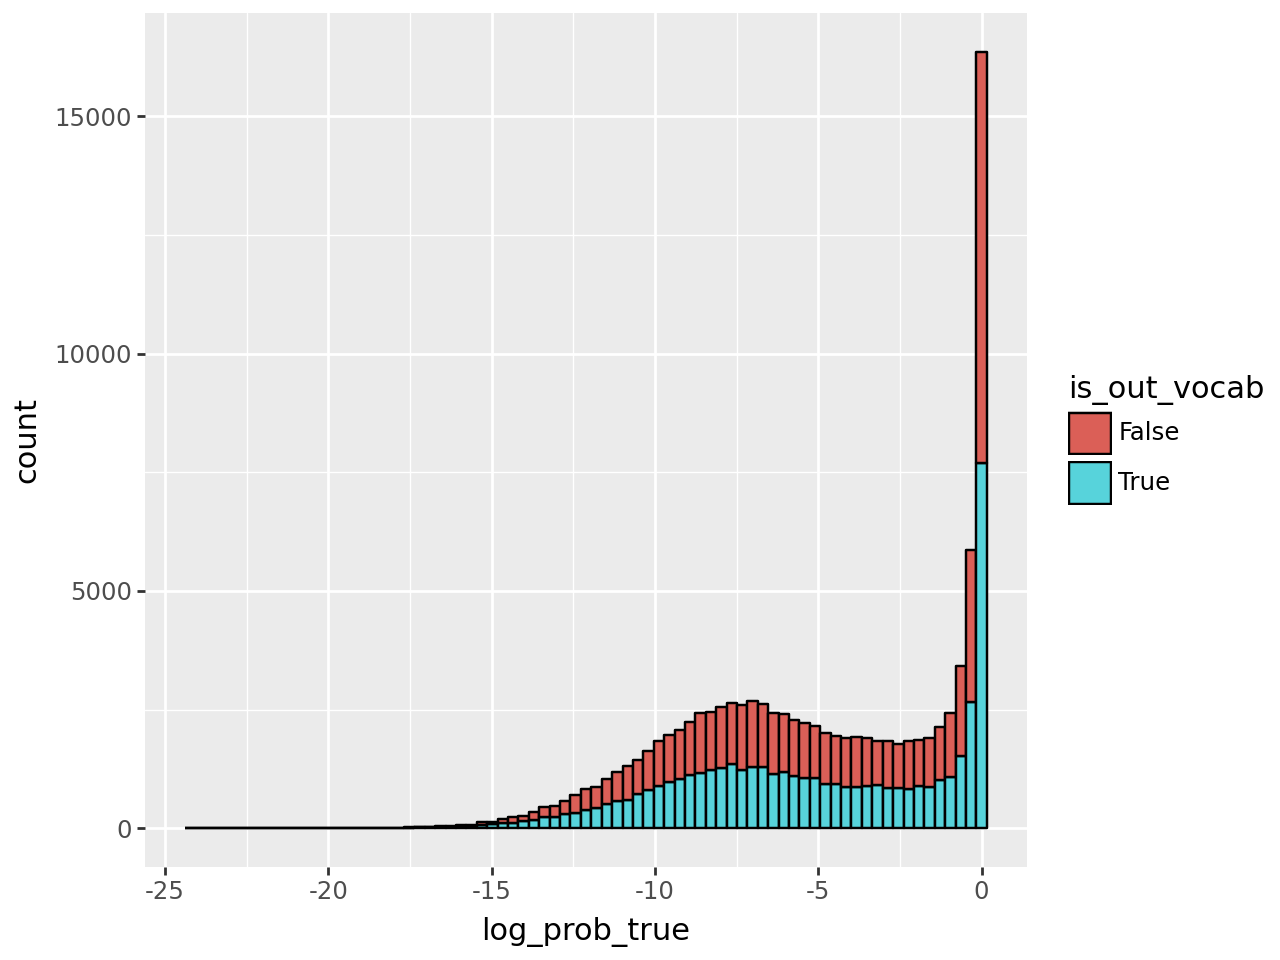

In [8]:
(pn.ggplot(df, pn.aes("log_prob_true", fill="is_out_vocab")) + pn.geom_histogram(colour="black"))

In [33]:
# Compute average log-prob per token across contexts
avg_df = df.group_by(["new_token_id", "is_out_vocab"]).agg(
    pl.col("log_prob_true").mean(), pl.col("log_prob_true_and_prefix").mean()
)

In [34]:
avg_df = avg_df.join(tok.select(["new_token_id", "count"]), on="new_token_id")

In [35]:
# for idx, col in enumerate(df.columns):
#     if df.dtypes[idx] not in (pl.Boolean, pl.List):
#         print(col, df[col].is_infinite().sum())

In [36]:
# Prepare for regression making the scale more compatible
avg_df = avg_df.with_columns(pl.col("new_token_id") / 1_000)

In [41]:
avg_df.head()

new_token_id,is_out_vocab,log_prob_true,log_prob_true_and_prefix,count,zscore
f64,bool,f64,f64,i64,f64
30.5,false,-9.978858,-9.978858,2969,-1.372579
30.501,false,-8.031097,-8.031097,2969,-0.678623
30.502,false,-8.433873,-8.433873,2969,-0.822126
30.503,false,-7.175922,-7.175922,2968,-0.373938
30.504,false,-1.655787,-1.655787,2968,1.592797


In [40]:
avg_df = avg_df.with_columns(
    zscore=(pl.col("log_prob_true") - pl.col("log_prob_true").mean()) / pl.col("log_prob_true").std()
)

In [58]:
avg_df.filter((pl.col("new_token_id") < 32. + .5) & (pl.col("new_token_id") > 32. - .5))

new_token_id,is_out_vocab,log_prob_true,log_prob_true_and_prefix,count,zscore
f64,bool,f64,f64,i64,f64
31.501,false,-5.777004,-5.777004,2801,0.124474
31.502,false,-2.481277,-2.481277,2801,1.298689
31.503,false,-9.668022,-9.668022,2801,-1.261833
31.504,false,-7.490189,-7.490189,2801,-0.485906
31.505,false,-1.212802,-1.212802,2801,1.750626
…,…,…,…,…,…
32.495,true,-5.66339,-5.66339,2652,0.164953
32.496,true,-9.086741,-8.979098,2652,-1.054732
32.497,true,-6.733489,-6.586963,2652,-0.216306


In [69]:
win = .1
regdata = avg_df.filter((pl.col("new_token_id") < 32 + win) & (pl.col("new_token_id") > 32 - win))

# Fit model
rdd = smf.ols(
    "zscore ~ new_token_id + is_out_vocab + new_token_id:is_out_vocab", 
    regdata.to_pandas()
).fit(cov_type="HC3")
# rdd = (
#     smf.ols(
#         "log_prob_true ~ count + is_out_vocab + count:is_out_vocab", 
#         avg_df.to_pandas()
#     )
#     .fit(cov_type="HC3")
# )

# Compute discontinuity at threasold
# discontinuity_at_threshold = rdd.predict({"new_token_id": [31.999, 32.0], "is_out_vocab": [False, True]}).to_dict()
# discontinuity_at_threshold = discontinuity_at_threshold[1] - discontinuity_at_threshold[0]
# print(discontinuity_at_threshold)

rdd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 zscore   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.5661
Date:                Wed, 02 Oct 2024   Prob (F-statistic):              0.638
Time:                        17:06:23   Log-Likelihood:                -265.61
No. Observations:                 198   AIC:                             539.2
Df Residuals:                     194   BIC:                             552.4
Df Model:                           3                                         
Covariance Type:                  HC3                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           -21.5530    112.984     -0.191      0.849    -242.998     199.891
is_out_vocab[T.True]                -40.3587    149.669     -0.270      0.787    -333.705     252.988
new_token_id                          0.6736      3.536      0.190      0.849      -6.257       7.604
new_token_id:is_out_vocab[T.True]     1.2620      4.678      0.270      0.787      -7.907      10.431
==============================================================================
Omnibus:                        1.084   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.582   Jarque-Bera (JB):                1.171
Skew:                           0.124   Prob(JB):                        0.557
Kurtosis:                       2.716   Cond. No.                     9.25e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 9.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

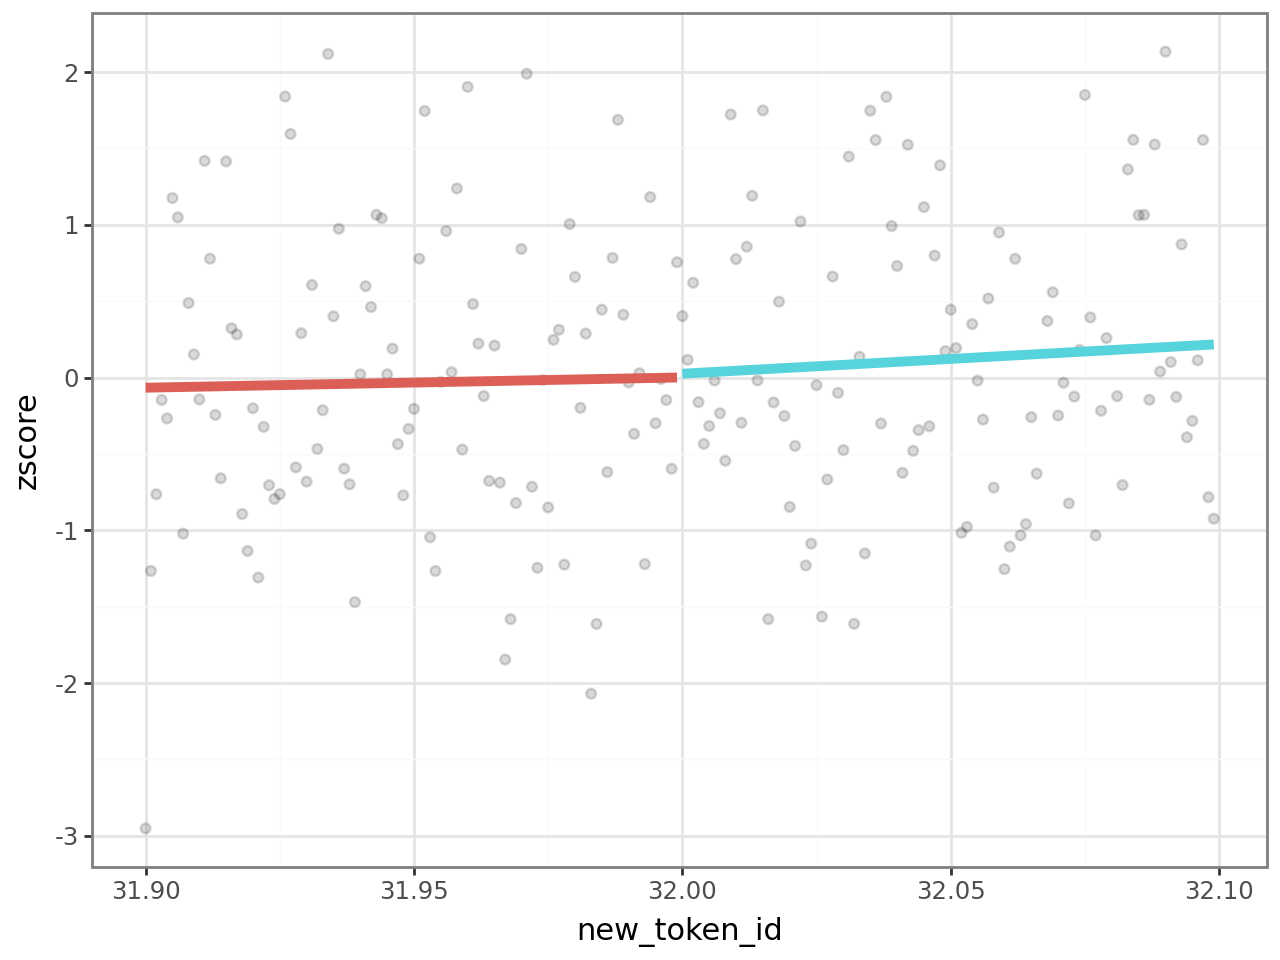

In [70]:
p = (
    pn.ggplot(regdata, pn.aes(x="new_token_id", y="zscore"))
    + pn.geom_point(alpha=0.15)
    + pn.geom_line(pn.aes(y=rdd.fittedvalues, color="is_out_vocab"), size=2)
    # + pn.coord_cartesian(ylim=(-8, -5))
    # + pn.geom_vline(xintercept=vocab_size / 1000, linetype="dashed", color="black")
    # + pn.scale_x_reverse()
    # + pn.labs(x="", y="", colour="", title=f"Discontinuity at threshold: {discontinuity_at_threshold:.2f}")
    + pn.scale_colour_discrete(guide=None)
    + pn.theme_bw()
    # pn.scale_y_log10()
)

p

In [28]:
avg_df.group_by("is_out_vocab").agg(pl.col("log_prob_true").mean())

is_out_vocab,log_prob_true
bool,f64
false,-5.981848
true,-6.271188


In [76]:
# Fit model
rdd = smf.ols(
    "log_prob_true_and_prefix ~ new_token_id + is_out_vocab + new_token_id:is_out_vocab", avg_df.to_pandas()
).fit(cov_type="HC3")

# Compute discontinuity at threasold
discontinuity_at_threshold = rdd.predict({"new_token_id": [31.999, 32.0], "is_out_vocab": [False, True]}).to_dict()
discontinuity_at_threshold = discontinuity_at_threshold[1] - discontinuity_at_threshold[0]
print(discontinuity_at_threshold)

rdd.summary()

-9.994307865796827


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     log_prob_true_and_prefix   R-squared:                       0.611
Model:                                  OLS   Adj. R-squared:                  0.611
Method:                       Least Squares   F-statistic:                     1560.
Date:                      Tue, 17 Sep 2024   Prob (F-statistic):               0.00
Time:                              12:36:17   Log-Likelihood:                -8356.8
No. Observations:                      2993   AIC:                         1.672e+04
Df Residuals:                          2989   BIC:                         1.675e+04
Df Model:                                 3                                         
Covariance Type:                        HC3                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           -13.7875      4.695     -2.937      0.003     -22.989      -4.586
is_out_vocab[T.True]                 -7.7385     11.060     -0.700      0.484     -29.415      13.938
new_token_id                          0.1023      0.150      0.681      0.496      -0.192       0.397
new_token_id:is_out_vocab[T.True]    -0.0705      0.341     -0.207      0.836      -0.738       0.597
==============================================================================
Omnibus:                       36.762   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.804
Skew:                           0.015   Prob(JB):                     1.40e-14
Kurtosis:                       3.715   Cond. No.                     6.20e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 6.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

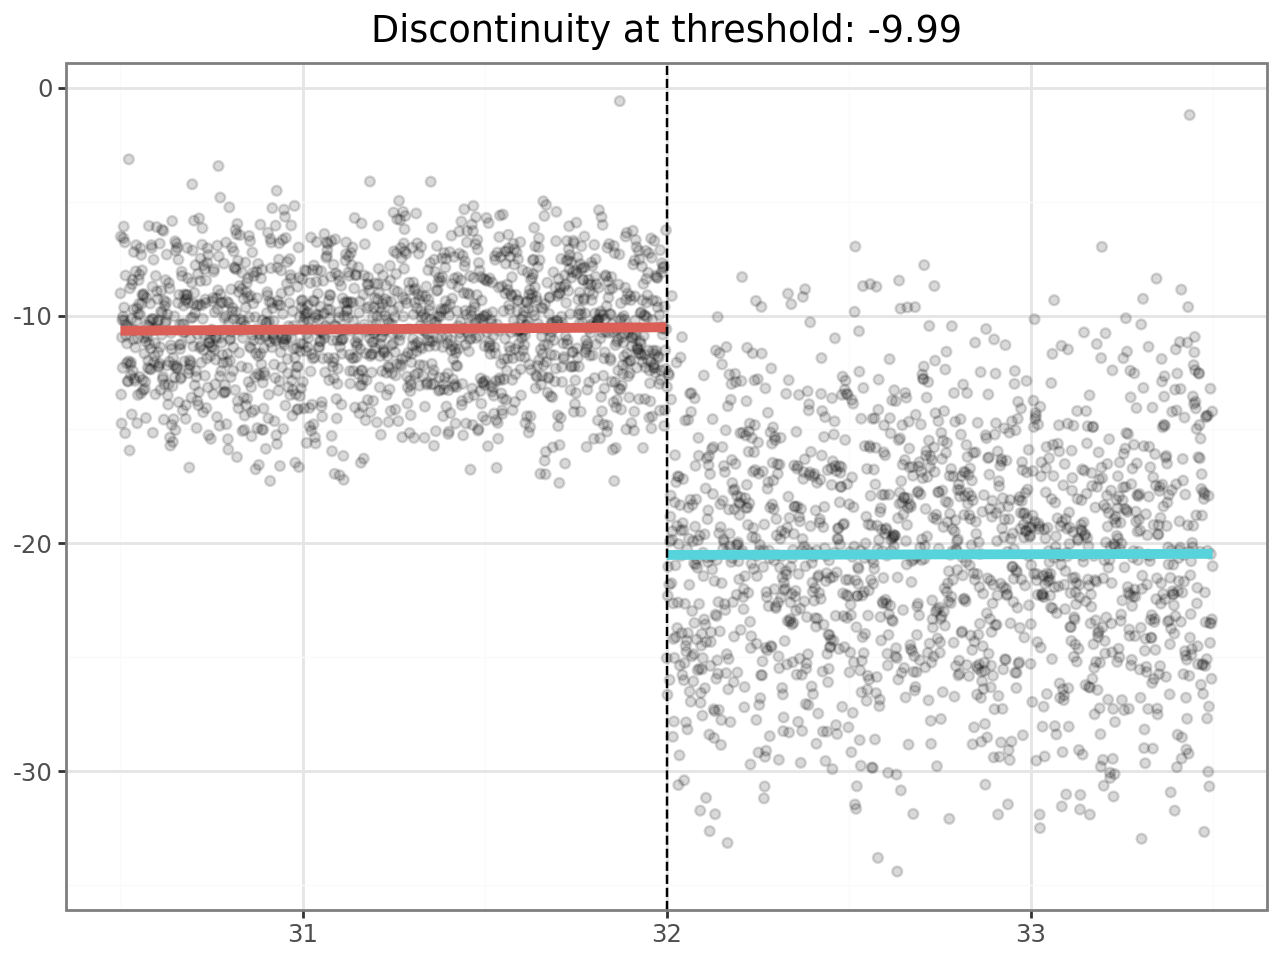

In [77]:
p = (
    pn.ggplot(avg_df, pn.aes(x="new_token_id", y="log_prob_true_and_prefix"))
    + pn.geom_point(alpha=0.15)
    + pn.geom_line(pn.aes(y=rdd.fittedvalues, color="is_out_vocab"), size=2)
    # pn.coord_cartesian(ylim=(4, 12)) +
    + pn.geom_vline(xintercept=vocab_size / 1000, linetype="dashed", color="black")
    + pn.labs(x="", y="", colour="", title=f"Discontinuity at threshold: {discontinuity_at_threshold:.2f}")
    + pn.scale_colour_discrete(guide=None)
    + pn.theme_bw()
    # pn.scale_y_log10()
)

p

----

In [102]:
from sklearn.linear_model import LinearRegression

result = cp.RegressionDiscontinuity(
    data=avg_df.to_pandas().rename(columns={"is_out_vocab": "treated"}),
    formula="log_prob_true ~ 1 + new_token_id + treated",
    model=LinearRegression(),
    treatment_threshold=vocab_size / 1_000,
    running_variable_name="new_token_id",
)

# fig, ax = result.plot()

(<Figure size 720x480 with 1 Axes>,
 <Axes: title={'center': '$R^2$ on all data = 0.7\nDiscontinuity at threshold = -12'}, xlabel='new_token_id', ylabel='log_prob_true'>)

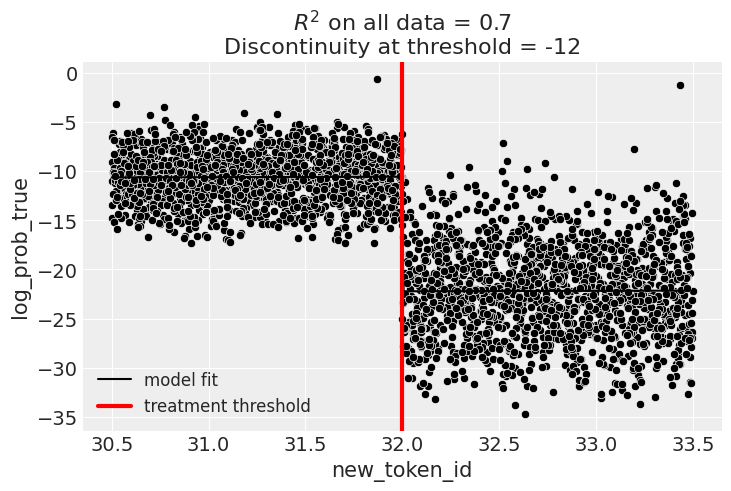

In [108]:
result.plot()

In [109]:
result.summary()

Difference in Differences experiment
Formula: log_prob_true ~ 1 + new_token_id + treated
Running variable: new_token_id
Threshold on running variable: 32.0

Results:
Discontinuity at threshold = -11.66


Model coefficients:
  Intercept      	         0
  treated[T.True]	       -12
  new_token_id   	     0.047


In [110]:
result.print_coefficients()

Model coefficients:
  Intercept      	         0
  treated[T.True]	       -12
  new_token_id   	     0.047
